In [1]:
%load_ext autoreload
%autoreload 2

In [335]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
import cv2

from tqdm.auto import tqdm


from einops import rearrange, repeat

from functools import partial

In [3]:
from mzr import *

In [449]:
class MazeEnv(gym.Env):
    def __init__(self, X=15, Y=15):
        self.X, self.Y = X, Y
        self.action_space = gym.spaces.Discrete(5)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(self.Y, self.X))

    def set_xy(self, x, y):
        self.x, self.y = x, y

    def reset(self):
        self.x, self.y = self.X//2, self.Y//2
        obs = np.zeros((self.Y, self.X), dtype=np.float32)
        obs[self.y, self.x] = 1.
        info = {'y': self.y, 'x': self.x}
        return obs, info

    def step(self, action):
        if action==0:
            pass
        elif action==1:
            self.y -= 1
        elif action==2:
            self.y += 1
        elif action==3:
            self.x -= 1
        elif action==4:
            self.x += 1
        
        self.y = np.clip(self.y, 0, self.Y-1)
        self.x = np.clip(self.x, 0, self.X-1)

        obs = np.zeros((self.Y, self.X), dtype=np.float32)
        obs[self.y, self.x] = 1.
        info = {'y': self.y, 'x': self.x}
        reward = 0
        terminated = False
        truncated = False
        return obs, reward, terminated, truncated, info

In [450]:
class ToTensorWrapper(gym.Wrapper):
    def __init__(self, env, device=None, dtype=None):
        super().__init__(env)
        self.device = device
        self.dtype = dtype

    def reset(self):
        obs, info = self.env.reset()
        obs = torch.as_tensor(obs, device=self.device, dtype=self.dtype)
        return obs, info
    
    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        obs = torch.as_tensor(obs, device=self.device, dtype=self.dtype)
        reward = torch.as_tensor(reward, device=self.device, dtype=self.dtype)
        terminated = torch.as_tensor(terminated, device=self.device, dtype=self.dtype)
        truncated = torch.as_tensor(truncated, device=self.device, dtype=self.dtype)
        return obs, reward, terminated, truncated, info

class MyRewardWrapper(gym.Wrapper):
    def __init__(self, env, rnet, loss_fn):
        super().__init__(env)
        self.goal = None
        self.loss_fn = loss_fn
        self.rnet = rnet
    
    def set_goal(self, goal):
        self.goal = goal

    def step(self, action):
        obs, _, terminated, truncated, info = self.env.step(action)
        latent = self.rnet(obs)
        loss = self.loss_fn(self.goal, latent)
        reward = -loss.detach()
        info['loss'] = loss
        return obs, reward, terminated, truncated, info


In [451]:
def loss_fn(goal, state_latent, strategy='euclidean'):
    if strategy=='euclidean':
        return (goal-state_latent).pow(2).mean(dim=-1)
    elif strategy=='dot':
        return -torch.cosine_similarity(goal, state_latent, dim=-1)

In [452]:
# class RepresentationNet(nn.Module):
#     def __init__(self, env, latent_size=20):
#         super().__init__()
#         self.encoder = nn.Sequential(
#             layer_init(nn.Conv2d(1, 10, 8, stride=4)),
#             nn.ReLU(),
#             layer_init(nn.Conv2d(10, 10, 4, stride=2)),
#             nn.ReLU(),
#             layer_init(nn.Conv2d(10, 10, 3, stride=2)),
#             nn.ReLU(),
#             layer_init(nn.Conv2d(10, 10, 3, stride=2)),
#             nn.ReLU(),
#             nn.Flatten(),
#             layer_init(nn.Linear(20, latent_size)),
#             nn.ReLU(),
#         )
#         self.latent_size = latent_size

#     def forward(self, obs):
#         return self.encoder(obs)

class RepresentationNet(nn.Module):
    def __init__(self, env, latent_size=20):
        super().__init__()
        self.encoder = nn.Sequential(
            layer_init(nn.Conv2d(1, 10, 3, padding=1)),
            nn.ReLU(),
            layer_init(nn.Conv2d(10, 10, 3, padding=1)),
            nn.ReLU(),
            nn.AvgPool2d(2),
            layer_init(nn.Conv2d(10, 10, 3, padding=1)),
            nn.ReLU(),
            layer_init(nn.Conv2d(10, 10, 3, padding=1)),
            nn.ReLU(),
            nn.AvgPool2d(2),
            layer_init(nn.Conv2d(10, 10, 3, padding=1)),
            nn.ReLU(),
            layer_init(nn.Conv2d(10, 10, 3, padding=1)),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Flatten(),
        )
        obs = env.single_observation_space.sample()
        x = torch.from_numpy(obs)[None, None]
        y = self.encoder(x)
        self.encoder.append(layer_init(nn.Linear(y.shape[-1], latent_size)))
        self.encoder.append(nn.Tanh())
        self.encoder.append(layer_init(nn.Linear(latent_size, latent_size)))
        self.encoder.append(nn.Tanh())
        self.latent_size = latent_size

    def forward(self, obs):
        return self.encoder(obs[..., None, :, :])

class GCPolicy(nn.Module):
    def __init__(self, env, latent_size=20, rnet=None, goal_size=2):
        super().__init__()
        if rnet is None:
            rnet = RepresentationNet(env, latent_size)
        self.rnet = rnet

        self.n_outputs = env.single_action_space.n
        self.critic = nn.Sequential(
            layer_init(nn.Linear(latent_size+goal_size, int(1.5*latent_size))),
            nn.ReLU(),
            layer_init(nn.Linear(int(1.5*latent_size), latent_size)),
            nn.ReLU(),
            layer_init(nn.Linear(latent_size, 1)),
        )
        self.actor = nn.Sequential(
            layer_init(nn.Linear(latent_size+goal_size, int(1.5*latent_size))),
            nn.ReLU(),
            layer_init(nn.Linear(int(1.5*latent_size), latent_size)),
            nn.ReLU(),
            layer_init(nn.Linear(latent_size, self.n_outputs), std=1e-5),
        )
        self.goal = None

    def set_goal(self, goal):
        self.goal = goal

    def get_logits_values(self, obs, goal=None):
        if goal is None:
            goal = self.goal
        latent = self.rnet(obs)
        # print(obs.shape, latent.shape, goal.shape)
        goal = goal.repeat(len(obs)//len(goal), 1)
        # print(obs.shape, latent.shape, goal.shape)
        latent_goal = torch.cat([latent, goal], dim=-1)
        logits, values = self.actor(latent_goal), self.critic(latent_goal)
        # if self.force_random:
        #     logits, values = torch.zeros_like(logits), torch.zeros_like(values)
        values = rearrange(values, '... 1 -> ...')
        return logits, values

    def get_value(self, obs, goal=None):
        return self.get_logits_values(obs, goal)[1]

    def get_action_and_value(self, obs, action=None, goal=None):
        if goal is None:
            goal = self.goal
        logits, values = self.get_logits_values(obs, goal)
        dist = torch.distributions.Categorical(logits=logits)
        if action is None:
            action = dist.sample()
        return action, dist.log_prob(action), dist.entropy(), values

In [471]:
a = gym.spaces.Box(low=0, high=255, shape=(84, 84), dtype=np.uint8)
b = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(3,), dtype=np.float32)
a = gym.spaces.Dict({'image': a, 'goal': b})

In [472]:
a.sample()

OrderedDict([('goal',
              array([-1.2256246 ,  1.1214067 ,  0.25447658], dtype=float32)),
             ('image',
              array([[ 14,  51,  99, ..., 184, 228, 135],
                     [139, 217, 144, ..., 138,  80, 125],
                     [ 78, 101,  68, ..., 175, 233,  12],
                     ...,
                     [174, 191, 218, ...,   8, 198, 251],
                     [120, 242,  50, ...,  13, 149,  50],
                     [  6, 117,  66, ..., 178, 166, 199]], dtype=uint8))])

In [453]:
def show_behavior(policy, rnet, goal, n_steps=20, n_envs=1000):
    env = gym.vector.SyncVectorEnv([MazeEnv for i in range(n_envs)])
    # env = gym.wrappers.TimeLimit(env, max_episode_steps=20)
    env = ToTensorWrapper(env, device=None, dtype=torch.float32)
    env = MyRewardWrapper(env, rnet, loss_fn=partial(loss_fn, strategy='dot'))
    env.set_goal(goal)
    env0 = env.envs[0]

    rewards = []
    pos = []
    obs, info = env.reset()
    for i in tqdm(range(n_steps)):
        with torch.no_grad():
            action, log_prob, entropy, values = policy.get_action_and_value(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        rewards.append(reward)
        x, y = info['x'], info['y']
        pos.append([x, y])
    pos = np.array(pos)
    pos = np.moveaxis(pos, 0, 1)

    print(f'Cumulative Reward: {torch.stack(rewards).mean(dim=-1).sum().item():.4f}')
    print(f' Mean Mean Reward: {torch.stack(rewards).mean(dim=-1).mean().item():.4f}')
    print(f'      Mean Reward: {torch.stack(rewards).mean().item():.4f}')
    print(f'       End Reward: {reward.mean(dim=-1).item():.4f}')


    r = np.random.randn(*pos.shape)
    a = pos + 3e-1*r
    c = np.arange(pos.shape[1])
    c = np.tile(c[:, None], (1, pos.shape[2]))
    a = a.reshape(2, -1)
    c = c.reshape(-1)

    plt.figure(figsize=(12, 4))
    plt.subplot(122)
    plt.scatter(*a, c=c)
    plt.colorbar()
    plt.title('Location vs Trajectory Time')
    plt.xlim(0, env0.X)
    plt.ylim(env0.Y, 0)

    env.reset()
    A = np.zeros((env0.X, env0.Y, n_envs))
    _, reward, _, _, _ = env0.step(0)
    for x in tqdm(range(env0.X)):
        for y in range(env0.Y):
            for envi in env.envs:
                envi.set_xy(x, y)
            _, reward, _, _, _ = env.step(np.zeros(n_envs))
            A[y, x, :] = reward.tolist()

    plt.subplot(121)
    plt.imshow(A.mean(axis=-1))
    plt.title('Reward Function')
    plt.colorbar()
    plt.show()

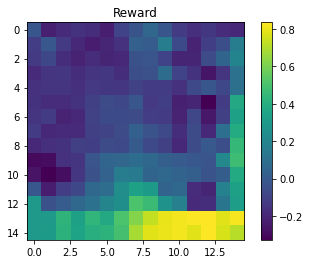

In [454]:
torch.manual_seed(9)
latent_size = 2

env = gym.vector.SyncVectorEnv([MazeEnv for i in range(1)])
# env = gym.wrappers.TimeLimit(env, max_episode_steps=20)
env = ToTensorWrapper(env, device=None, dtype=torch.float32)

rnet = RepresentationNet(env, latent_size=latent_size)
goal = torch.randn(1, latent_size)

env = MyRewardWrapper(env, rnet, loss_fn=partial(loss_fn, strategy='dot'))
env.set_goal(goal)

env0 = env.envs[0]

A = np.zeros((env0.Y, env0.X))
for x in range(env0.X):
    for y in range(env0.Y):
        env.reset()
        for envi in env.envs:
            envi.set_xy(x, y)
        obs, reward, _, _, _ = env.step(np.zeros(1))
        latent = rnet(obs)
        loss = loss_fn(goal, latent, strategy='dot')
        assert torch.allclose(reward, -loss) # sanity check
        A[y, x] = reward.mean().item()

plt.title('Reward')
plt.imshow(A)
plt.colorbar()

In [455]:
env = gym.vector.SyncVectorEnv([MazeEnv for i in range(100)])
# env = gym.wrappers.TimeLimit(env, max_episode_steps=20)
env = ToTensorWrapper(env, device=None, dtype=torch.float32)
env = MyRewardWrapper(env, rnet, loss_fn=partial(loss_fn, strategy='dot'))
env.set_goal(goal)

obs, info = env.reset()
obs, reward, terminated, truncated, info = env.step(np.zeros(100))
print(obs.shape, reward.shape, terminated.shape, truncated.shape, info.keys())

print(f'Center reward: {A[7, 7]}')
print(f'  Mean reward: {A.mean()}')
print(f'   Min reward: {A.min()}')
print(f'   Max reward: {A.max()}')

# rnet
policy = GCPolicy(env, latent_size=10, rnet=None)
policy.set_goal(repeat(goal, '1 n -> e n', e=100))
action, log_prob, entropy, values = policy.get_action_and_value(torch.from_numpy(env.observation_space.sample()))

torch.Size([100, 15, 15]) torch.Size([100]) torch.Size([100]) torch.Size([100]) dict_keys(['y', '_y', 'x', '_x', 'loss'])
Center reward: 0.030511975288391113
  Mean reward: 0.0355209928088718
   Min reward: -0.32744014263153076
   Max reward: 0.8359813094139099


100%|██████████| 20/20 [00:00<00:00, 69.59it/s]


Cumulative Reward: -1.0521
 Mean Mean Reward: -0.0526
      Mean Reward: -0.0526
       End Reward: -0.0502


100%|██████████| 15/15 [00:01<00:00,  9.93it/s]


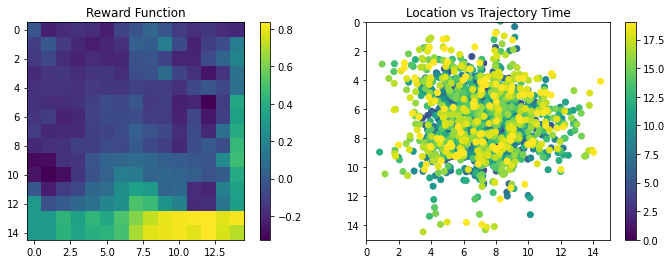

In [456]:
show_behavior(policy, rnet, goal, n_envs=100)

In [457]:
r = []
obs, info = env.reset()
for i_step in range(20):
    with torch.no_grad():
        action, logprob, entropy, value = policy.get_action_and_value(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    r.append(reward)
r = torch.stack(r)
print(r.mean())

tensor(-0.0284)


Namespace(exp_name='ppo_simple', seed=1, torch_deterministic=True, cuda=True, track=False, wandb_project_name='cleanRL', wandb_entity=None, capture_video=False, total_timesteps=10000000, learning_rate=0.0003, num_steps=20, anneal_lr=True, gamma=0.99, gae_lambda=0.95, num_minibatches=4, update_epochs=4, norm_adv=True, clip_coef=0.1, clip_vloss=True, ent_coef=0.01, vf_coef=0.5, max_grad_norm=0.5, target_kl=None, num_envs=100, batch_size=2000, minibatch_size=500)
00001: -0.0462
00002: -0.0302
00003: -0.0428
00004: -0.0256
00005: -0.0339
00006: 0.0079
00007: 0.0411
00008: 0.0891
00009: 0.1588
00030: 0.5464
00060: 0.5915
00090: 0.5862


100%|██████████| 20/20 [00:00<00:00, 86.80it/s]


Cumulative Reward: 11.8024
 Mean Mean Reward: 0.5901
      Mean Reward: 0.5901
       End Reward: 0.7617


100%|██████████| 15/15 [00:01<00:00,  9.17it/s]


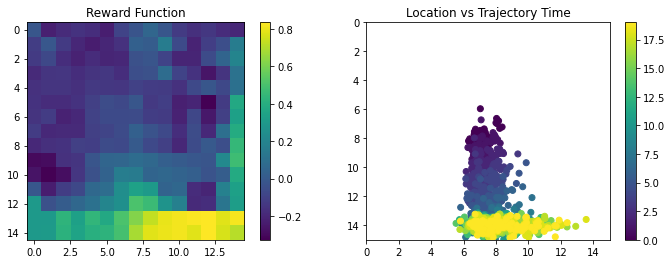

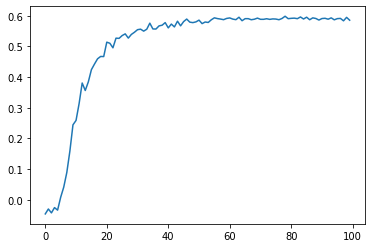

KeyboardInterrupt: 

In [458]:
import ppo
import ppo_simple

rewards = []
def callback_fn(update, **kwargs):
    if update<10 or update%30==0:
        print(f'{update:05d}: {kwargs["rewards"].mean().item():.4f}')
    rewards.append(kwargs['rewards'].mean().item())

    if update%100==0:
        show_behavior(policy, rnet, goal, n_envs=100)
        plt.plot(rewards)
        plt.show()

args = ppo_simple.parse_args(env, s='--learning-rate 3e-4 --num-steps 20'.split())
print(args)
ppo_simple.run_ppo_simple(policy, env, args, callback_fn=callback_fn)

100%|██████████| 20/20 [00:00<00:00, 48.98it/s]


Cumulative Reward: 11.8022
 Mean Mean Reward: 0.5901
      Mean Reward: 0.5901
       End Reward: 0.7831


100%|██████████| 15/15 [00:01<00:00,  9.03it/s]


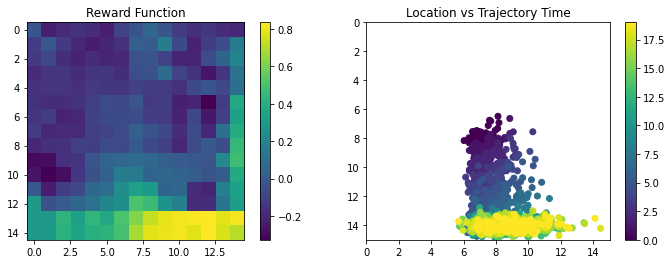

In [460]:
show_behavior(policy, rnet, goal, n_envs=100)

In [461]:
r = []
obs, info = env.reset()
for i_step in range(20):
    with torch.no_grad():
        action, logprob, entropy, value = policy.get_action_and_value(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    r.append(reward)
r = torch.stack(r)
print(r.mean())

tensor(0.5928)


In [464]:
enva = gym.vector.SyncVectorEnv([MazeEnv for i in range(100)])
# env = gym.wrappers.TimeLimit(env, max_episode_steps=20)
enva = ToTensorWrapper(enva, device=None, dtype=torch.float32)
enva = MyRewardWrapper(enva, rnet, loss_fn=partial(loss_fn, strategy='dot'))
enva.set_goal(goal)

# enva = env

torch.manual_seed(0)
np.random.seed(0)
r = []
obs, info = enva.reset()
for i_step in range(20):
    with torch.no_grad():
        action, logprob, entropy, value = policy.get_action_and_value(obs)
    obs, reward, terminated, truncated, info = enva.step(action)
    print(reward.mean().item())

    r.append(reward)
r = torch.stack(r)
print(r.mean().item())

-0.002695894567295909
0.05746328458189964
0.12801428139209747
0.22419586777687073
0.39986366033554077
0.48949000239372253
0.6331911087036133
0.7138310074806213
0.7553466558456421
0.7615125775337219
0.7695532441139221
0.7707704901695251
0.7733189463615417
0.7753860950469971
0.7781303524971008
0.7800938487052917
0.7819210290908813
0.7826184034347534
0.786719560623169
0.7859001755714417
0.5972312688827515


In [462]:
import ppo

torch.manual_seed(0)
goal = torch.randn(100, 10)

env = gym.vector.SyncVectorEnv([MazeEnv for i in range(100)])
env = ToTensorWrapper(env, device=None, dtype=torch.float32)
env = MyRewardWrapper(env, rnet, loss_fn=partial(loss_fn, strategy='dot'))
env.set_goal(goal)

rnet = RepresentationNet(env, latent_size=10)
policy = GCPolicy(env, latent_size=10, rnet=None)
policy.set_goal(goal)

opt = torch.optim.Adam(rnet.parameters(), lr=1e-3)

def update_rnet():
    pass

def callback_fn(i_step, **kwargs):
    # goal = torch.randn(100, 10)
    # env.set_goal(goal)
    # policy.set_goal(goal)
    # print(kwargs['obs'].shape)
    print(f'{i_step:05d}: {kwargs["rewards"].mean().item():.4f}')

args = ppo.parse_args(env, s=None)
ppo.run_ppo(policy, env, args, callback_fn=callback_fn)

00001: 0.0210
00002: 0.0448
00003: 0.0564
00004: 0.0516
00005: 0.0566
00006: 0.0644
00007: 0.0728
00008: 0.0681
00009: 0.0663
00010: 0.0674
00011: 0.0639
00012: 0.0674
00013: 0.0623
00014: 0.0682
00015: 0.0671
00016: 0.0706
00017: 0.0665
00018: 0.0669
00019: 0.0701
00020: 0.0678
00021: 0.0656
00022: 0.0686
00023: 0.0674
00024: 0.0674
00025: 0.0667
00026: 0.0714
00027: 0.0815
00028: 0.0713
00029: 0.0766
00030: 0.0808
00031: 0.0733
00032: 0.0745
00033: 0.0699
00034: 0.0683


KeyboardInterrupt: 

In [446]:
policy.goal.shape

torch.Size([100, 10])

In [601]:
env = gym.make('MontezumaRevenge-v4', frameskip=1)
env = gym.wrappers.AtariPreprocessing(env)

obs, info = env.reset()
print(obs.shape, info)
for i in range(10):
    obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
    print(obs.shape, reward, terminated, truncated, info)

A.L.E: Arcade Learning Environment (version 0.8.0+919230b)
[Powered by Stella]


(84, 84) {'lives': 6, 'episode_frame_number': 8, 'frame_number': 8}
(84, 84) 0.0 False False {'lives': 6, 'episode_frame_number': 12, 'frame_number': 12}
(84, 84) 0.0 False False {'lives': 6, 'episode_frame_number': 16, 'frame_number': 16}
(84, 84) 0.0 False False {'lives': 6, 'episode_frame_number': 20, 'frame_number': 20}
(84, 84) 0.0 False False {'lives': 6, 'episode_frame_number': 24, 'frame_number': 24}
(84, 84) 0.0 False False {'lives': 6, 'episode_frame_number': 28, 'frame_number': 28}
(84, 84) 0.0 False False {'lives': 6, 'episode_frame_number': 32, 'frame_number': 32}
(84, 84) 0.0 False False {'lives': 6, 'episode_frame_number': 36, 'frame_number': 36}
(84, 84) 0.0 False False {'lives': 6, 'episode_frame_number': 40, 'frame_number': 40}
(84, 84) 0.0 False False {'lives': 6, 'episode_frame_number': 44, 'frame_number': 44}
(84, 84) 0.0 False False {'lives': 6, 'episode_frame_number': 48, 'frame_number': 48}


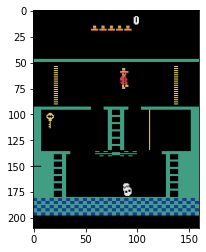

In [127]:
plt.imshow(obs)

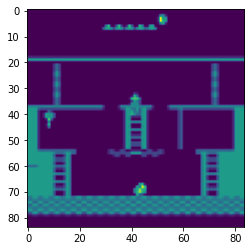

In [125]:
plt.imshow(obs)

In [131]:
from functools import partial

def make_env(env_id, seed, idx, capture_video, run_name):
    env = gym.make(env_id, frameskip=1)
    env = gym.wrappers.AtariPreprocessing(env)
    if capture_video:
        if idx == 0:
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
    env = gym.wrappers.RecordEpisodeStatistics(env)
    env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    return env

env_id = 'MontezumaRevenge-v4'
n_envs = 10

envs = gym.vector.SyncVectorEnv(
    [partial(make_env, env_id=env_id, seed=i, idx=i, capture_video=False, run_name='run_name') for i in range(n_envs)]
)


In [147]:
obs, info = envs.reset()

obs, reward, terminated, truncated, info = envs.step(envs.action_space.sample())
obs.shape, reward.shape, terminated.shape, truncated.shape, info.keys()

((10, 84, 84),
 (10,),
 (10,),
 (10,),
 dict_keys(['lives', '_lives', 'episode_frame_number', '_episode_frame_number', 'frame_number', '_frame_number']))

In [142]:
info

{'lives': array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6]),
 '_lives': array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]),
 'episode_frame_number': array([ 7, 17, 30, 34, 11, 19, 19, 13, 12, 31]),
 '_episode_frame_number': array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]),
 'frame_number': array([113, 111, 145, 139,  94, 141, 138, 107,  93, 153]),
 '_frame_number': array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True])}

In [ ]:
batch_size = 32
latent_size = 2
env = MZRevenge(n_envs=batch_size)

rnet = RepresentationNet(env, latent_size)
policy = GCPolicy(env, latent_size, rnet=None) # keep separate rnet

opt = torch.optim.Adam(rnet.parameters(), lr=5e-4)


losses = []
pbar = tqdm(range(100))
for i in pbar:
    goal = torch.randn(batch_size, latent_size)

    _, obs, reward, done, info = env.reset()
    o = []
    for i in range(50):
        action, log_prob, entropy, values = policy.get_action_and_value(obs, goal)
        _, obs, reward, done, info = env.step(action.tolist())
        o.append(obs)
    o = torch.stack(o, dim=1)
    # o = o[:, -1]
    # print(o.shape)

    o_flat = rearrange(o, 'g t c h w -> (g t) c h w')
    latent = rnet(o_flat)
    latent = rearrange(latent, '(g t) l -> g t l', g=len(goal))
    # print(goal.shape, latent.shape)
    loss = loss_fn(goal[:, None, :], latent).mean()
    loss.backward()

    if i%10==0:
        opt.step()
        opt.zero_grad()

    losses.append(loss.item())
    pbar.set_postfix(loss=loss.item())

In [ ]:

batch_size = 32
latent_size = 2
env = MZRevenge(n_envs=batch_size)

rnet = RepresentationNet(env, latent_size)
policy1 = GCPolicy(env, latent_size, rnet=None) # keep separate rnet
policy2 = GCPolicy(env, latent_size, rnet=None) # keep separate rnet

_, obs, reward, done, info = env.reset()
o = []
for i in tqdm(range(50)):
    action, log_prob, entropy, values = policy1.get_action_and_value(obs, goal)
    _, obs, reward, done, info = env.step(action.tolist())
    o.append(obs)
o = torch.stack(o, dim=1)



In [307]:
def calc_gae(rewards, values, gamma=0.99, gae_lambda=0.95):
    """
    Generalized Advantage Estimation
    rewards, values should have shape (n_trajs, len_traj)
    Return value:
     - advantages, returns of shape (n_trajs, len_traj-1)
    """
    n_trajs, len_traj = rewards.shape
    t = torch.arange(len_traj).expand(n_trajs, -1)

    values_now, values_next = values[..., :-1], values[..., 1:]
    rewards_now, rewards_next = rewards[..., :-1], rewards[..., 1:]
    t_now, t_next = t[..., :-1], t[..., 1:]

    # Compute temporal difference residual (TDR)
    # shape: (n_trajs, len_traj-1)
    tdr_now = (rewards_now + gamma*values_next) - values_now
    def reverse_cumsum(x, dim=0): # cumsum from the end
        return x + x.sum(dim=dim, keepdims=True) - torch.cumsum(x, dim=dim)

    # advantages = ((gamma*gae_lambda)**t_now) * tdr_now
    # advantages = reverse_cumsum(advantages, dim=-1)

    advantages = torch.zeros_like(tdr_now)
    for i in range(0, len_traj-1):
        l = torch.arange(0, len_traj-1-i)
        advantages[:, i] = (((gamma*gae_lambda)**l) * tdr_now[:, i:]).sum(dim=-1)

    # adv = torch.zeros_like(tdr_now)
    # for i in range(0, len_traj-1):
    #     for l in range(0, len_traj-1):
    #         if i+l>=len_traj-1:
    #             break
    #         adv[:, i] += (gamma*gae_lambda)**(l) * tdr_now[:, i+l]
        
    returns = advantages + values_now
    return advantages, returns

def calc_manual_gae(rewards, values, gamma=0.99, gae_lambda=0.95):
    """
    Generalized Advantage Estimation
    rewards, values should have shape (n_trajs, len_traj)
    Return value:
     - advantages, returns of shape (n_trajs, len_traj-1)
    """
    n_trajs, len_traj = rewards.shape
    t = torch.arange(len_traj).expand(n_trajs, -1)

    values_now, values_next = values[..., :-1], values[..., 1:]
    rewards_now, rewards_next = rewards[..., :-1], rewards[..., 1:]
    t_now, t_next = t[..., :-1], t[..., 1:]

    # Compute temporal difference residual (TDR)
    # shape: (n_trajs, len_traj-1)
    tdr_now = (rewards_now + gamma*values_next) - values_now

    adv = torch.zeros_like(tdr_now)
    for i in range(0, len_traj-1):
        for l in range(0, len_traj-1):
            if i+l>=len_traj-1:
                break
            adv[:, i] += (gamma*gae_lambda)**(l) * tdr_now[:, i+l]
    # return tdr_now, _
    return adv, None

torch.manual_seed(0)
rewards = torch.randn(100, 21)
values = torch.randn(100, 21)

a, _ = calc_gae(rewards, values)
b, _ = calc_manual_gae(rewards, values)

print(torch.allclose(a, b))

False
